In [9]:
#starting imports we will need 
#Pandas is python's data analysis library, which makes it 
#much easier to work with the data.

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

In [10]:
#Reading in the data from the csv files provided on Kaggle.
#skipping 2001 - 2004 due to bad quality, panda doesn't load them nicely

crimes1 = pd.read_csv('../input/Chicago_Crimes_2005_to_2007.csv',error_bad_lines=False)
crimes2 = pd.read_csv('../input/Chicago_Crimes_2008_to_2011.csv',error_bad_lines=False)
crimes3 = pd.read_csv('../input/Chicago_Crimes_2012_to_2017.csv',error_bad_lines=False)
data = pd.concat([crimes1, crimes2, crimes3], ignore_index=False, axis=0)

del crimes1
del crimes2
del crimes3

b'Skipping line 533719: expected 23 fields, saw 24\n'
b'Skipping line 1149094: expected 23 fields, saw 41\n'


In [11]:
#Next we need to clean up the data

data.drop_duplicates(subset=['ID', 'Case Number'], inplace=True)

data = data.drop(['Unnamed: 0', 'Case Number', 'Updated On','Community Area', 'Latitude', 'Longitude', 'Location'], axis=1)

# convert dates to pandas datetime format
data.Date = pd.to_datetime(data.Date, format='%m/%d/%Y %I:%M:%S %p')

# setting the index to be the date will help later on
data.index = pd.DatetimeIndex(data.Date)

#next, make the data less noisy by only keeping the top 20 location descriptions and crime descriptions
loc_to_change  = list(data['Location Description'].value_counts()[20:].index)
desc_to_change = list(data['Description'].value_counts()[20:].index)

data.loc[data['Location Description'].isin(loc_to_change), data.columns=='Location Description'] = 'OTHER'
data.loc[data['Description'].isin(desc_to_change), data.columns=='Description'] = 'OTHER'

In [12]:
#do some unsupervised learning and try to cluster the data
#we will print out the results with heat maps

from sklearn.cluster import AgglomerativeClustering as AC

def scale_df(df,axis=0):
    '''
    A utility function to scale numerical values (z-scale) to have a mean of zero
    and a unit variance.
    '''
    return (df - df.mean(axis=axis)) / df.std(axis=axis)

def plot_hmap(df, ix=None, cmap='bwr'):
    '''
    A function to plot heatmaps that show temporal patterns
    '''
    if ix is None:
        ix = np.arange(df.shape[0])
    plt.imshow(df.iloc[ix,:], cmap=cmap)
    plt.colorbar(fraction=0.03)
    plt.yticks(np.arange(df.shape[0]), df.index[ix])
    plt.xticks(np.arange(df.shape[1]))
    plt.grid(False)
    plt.show()
    
def scale_and_plot(df, ix = None):
    '''
    A wrapper function to calculate the scaled values within each row of df and plot_hmap
    '''
    df_marginal_scaled = scale_df(df.T).T
    if ix is None:
        ix = AC(4).fit(df_marginal_scaled).labels_.argsort() # a trick to make better heatmaps
    cap = np.min([np.max(df_marginal_scaled.as_matrix()), np.abs(np.min(df_marginal_scaled.as_matrix()))])
    df_marginal_scaled = np.clip(df_marginal_scaled, -1*cap, cap)
    plot_hmap(df_marginal_scaled, ix=ix)
    
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

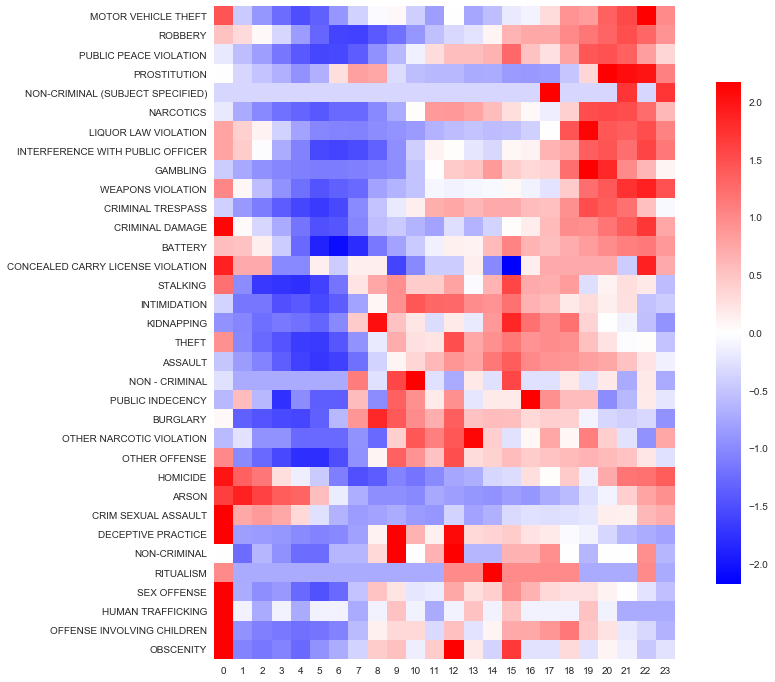

In [13]:
#lets plot the most likely times each crime will occur in a given day.
#red means the crime is most likely to occur at these times, blue means it is least likely to occur, and white means 
#the crime may occur at these times.

hour_by_type = data.pivot_table(values='ID', index='Primary Type', columns=data.index.hour, aggfunc=np.size).fillna(0)
plt.figure(figsize=(15,12))
scale_and_plot(hour_by_type)

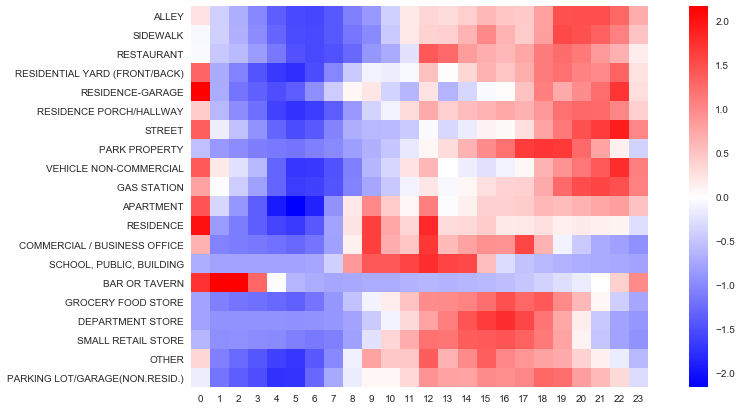

In [14]:
#we can also plot the most likely times that a crime will occur at a given location

hour_by_location = data.pivot_table(values='ID', index='Location Description', columns=data.index.hour, aggfunc=np.size).fillna(0)
plt.figure(figsize=(15,7))
scale_and_plot(hour_by_location)

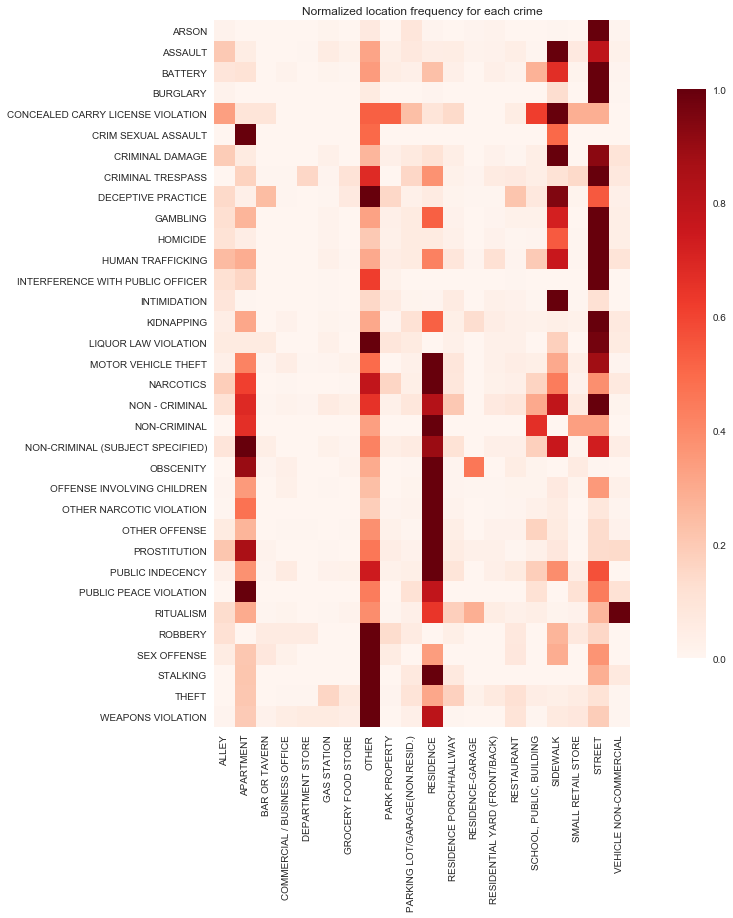

In [15]:
#lastly we plot the most likely location at which certain crimes will occur

location_by_type = data.pivot_table(values='ID', index='Location Description', columns='Primary Type', aggfunc=np.size).fillna(0)
df = normalize(location_by_type)
ix = AC(3).fit(df.T).labels_.argsort() # a trick to make better heatmaps
plt.figure(figsize=(17,13))
plt.imshow(df.T.iloc[ix,:], cmap='Reds')
plt.colorbar(fraction=0.03)
plt.xticks(np.arange(df.shape[0]), df.index, rotation='vertical')
plt.yticks(np.arange(df.shape[1]), df.columns)
plt.title('Normalized location frequency for each crime')
plt.grid(False)
plt.show()

In [16]:
data.head(3)

,ID,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,FBI Code,X Coordinate,Y Coordinate,Year
Date,,,,,,,,,,,,,,,,
2006-04-02 13:00:00,4673626,2006-04-02 13:00:00,055XX N MANGO AVE,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False,1622,16.0,45.0,26,1136872.0,1936499.0,2006
2006-02-26 13:40:48,4673627,2006-02-26 13:40:48,065XX S RHODES AVE,2017,NARCOTICS,OTHER,SIDEWALK,True,False,321,3.0,20.0,18,1181027.0,1861693.0,2006
2006-01-08 23:16:00,4673628,2006-01-08 23:16:00,013XX E 69TH ST,051A,ASSAULT,OTHER,OTHER,False,False,321,3.0,5.0,04A,1186023.0,1859609.0,2006


In [29]:
#we are going to predict where future crimes will occur, based off a 
#decision tree
#the heat map showed us that we should be able to narrow a crime 
#down to top three most likely locations, can we narrow it down to one?

#data preprocessing, we want to convert to numeric features
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()

data['Location Description'] = data['Location Description'].fillna('UNKNOWN')

lb_make = lb_make.fit(data['Location Description'])
data['Location Description'] = lb_make.transform(data['Location Description'])

#convert date to just the hour, didn't seem to make a substantial difference
data['Date'] = data.index.hour

lb_make = lb_make.fit(data['Block'])
data['Block'] = lb_make.transform(data['Block'])

lb_make = lb_make.fit(data['FBI Code'])
data['FBI Code'] = lb_make.transform(data['FBI Code'])

lb_make = lb_make.fit(data['IUCR'])
data['IUCR'] = lb_make.transform(data['IUCR'])

lb_make = lb_make.fit(data['Primary Type'])
data['Primary Type'] = lb_make.transform(data['Primary Type'])

lb_make = lb_make.fit(data['Description'])
data['Description'] = lb_make.transform(data['Description'])

X = data.drop('Location Description', axis = 1)
y =  data['Location Description']

class0 = data[y == 0]
class1 = data[y == 1]
class2 = data[y == 2]
class3 = data[y == 3]
class4 = data[y == 4]
class5 = data[y == 5]
class6 = data[y == 6]
class7 = data[y == 7]
class8 = data[y == 8]
class9 = data[y == 9]
class10 = data[y == 10]
class11 = data[y == 11]
class12 = data[y == 12]
class13 = data[y == 13]
class14 = data[y == 14]
class15 = data[y == 15]
class16 = data[y == 16]
class17 = data[y == 17]
class18 = data[y == 18]
class19 = data[y == 19]
class20 = data[y == 20]

from sklearn.utils import resample
class0 = resample(class0, replace=True, n_samples = 300000)
class1 = resample(class1, replace=True, n_samples = 300000)
class2 = resample(class2, replace=True, n_samples = 300000)
class3 = resample(class3, replace=True, n_samples = 300000)
class4 = resample(class4, replace=True, n_samples = 300000)
class5 = resample(class5, replace=True, n_samples = 300000)
class6 = resample(class6, replace=True, n_samples = 300000)
class7 = resample(class7, replace=True, n_samples = 300000)
class8 = resample(class8, replace=True, n_samples = 300000)
class9 = resample(class9, replace=True, n_samples = 300000)
class10 = resample(class10, replace=True, n_samples = 300000)
class11 = resample(class11, replace=True, n_samples = 300000)
class12 = resample(class12, replace=True, n_samples = 300000)
class13 = resample(class13, replace=True, n_samples = 300000)
class14 = resample(class14, replace=True, n_samples = 300000)
class15 = resample(class15, replace=True, n_samples = 300000)
class16 = resample(class16, replace=True, n_samples = 300000)
class17 = resample(class17, replace=True, n_samples = 300000)
class18 = resample(class18, replace=True, n_samples = 300000)
class19 = resample(class19, replace=True, n_samples = 300000)
class20 = resample(class20, replace=True, n_samples = 300000)

balanced = pd.concat([class0, class1, class2, class3, class4, class5, class6, class7, class8, class9, class10, class11, class12, class13, class14, class15, class16, class17, class18, class19, class20])
balanced['Location Description'].value_counts()

from sklearn.model_selection import train_test_split
X = balanced.drop('Location Description', axis = 1)
y =  balanced['Location Description']
x_train, dummy, y_train, dummy2 = train_test_split(X, y)

X = data.drop('Location Description', axis = 1)
y =  data['Location Description']
dummy, x_test, dummy2, y_test = train_test_split(X, y)

x_train = x_train.fillna(0)
y_train = y_train.fillna(0)
x_test = x_test.fillna(0)
y_test = y_test.fillna(0)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

print(data.head(3))

                     Date  Block  IUCR  Primary Type  Description  \
Date                                                                
2006-04-02 13:00:00    13  23520   311            24            7   
2006-02-26 13:40:48    13  26939   270            17            8   
2006-01-08 23:16:00    23   6684    66             1            8   

                     Location Description  Arrest  Domestic  Beat  District  \
Date                                                                          
2006-04-02 13:00:00                    10   False     False  1622      16.0   
2006-02-26 13:40:48                    16    True     False   321       3.0   
2006-01-08 23:16:00                     7   False     False   321       3.0   

                     Ward  FBI Code  Year  
Date                                       
2006-04-02 13:00:00  45.0        25  2006  
2006-02-26 13:40:48  20.0        20  2006  
2006-01-08 23:16:00   5.0         4  2006  


In [30]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)

predictions = clf.predict(x_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))


             precision    recall  f1-score   support

          0       0.40      0.91      0.55     24379
          1       0.61      0.57      0.59    122558
          2       0.51      1.00      0.67      6187
          3       0.46      0.99      0.63      6902
          4       0.69      0.96      0.80     13173
          5       0.48      0.99      0.65     11258
          6       0.62      0.98      0.76     12518
          7       0.67      0.50      0.57    147328
          8       0.47      1.00      0.64      8728
          9       0.43      0.87      0.58     30085
         10       0.71      0.51      0.59    178259
         11       0.41      0.95      0.57     18637
         12       0.50      0.95      0.66     21399
         13       0.40      0.98      0.56     14268
         14       0.52      0.94      0.67     16446
         15       0.65      0.97      0.78     22639
         16       0.61      0.55      0.58    120323
         17       0.57      0.87      0.69   

In [31]:
#time to train our neural network
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(20), activation = 'logistic', max_iter = 50)
mlp.fit(x_train, y_train)

C:\Users\Shawn\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=20, learning_rate='constant',
       learning_rate_init=0.001, max_iter=50, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [32]:
#time to do predictions and evaluation
predictions = mlp.predict(x_test)
# from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.07      0.29      0.12     24379
          1       0.35      0.32      0.34    122558
          2       0.06      0.64      0.11      6187
          3       0.05      0.29      0.09      6902
          4       0.38      0.50      0.43     13173
          5       0.08      0.20      0.11     11258
          6       0.27      0.19      0.22     12518
          7       0.45      0.02      0.04    147328
          8       0.04      0.16      0.06      8728
          9       0.12      0.21      0.15     30085
         10       0.52      0.17      0.25    178259
         11       0.04      0.07      0.05     18637
         12       0.13      0.70      0.22     21399
         13       0.05      0.15      0.08     14268
         14       0.13      0.16      0.14     16446
         15       0.15      0.63      0.24     22639
         16       0.32      0.23      0.27    120323
         17       0.27      0.19      0.22   

In [ ]:
#next we will try to run a neural network to predict if a crime ended in an arrest
X = data.drop('Arrest', axis = 1)
y =  data['Arrest']

x_train, x_test, y_train, y_test = train_test_split(X, y)

x_train = x_train.fillna(0)
y_train = y_train.fillna(0)
x_test = x_test.fillna(0)
y_test = y_test.fillna(0)

scaler = StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

#time to train a new neural network

mlp = MLPClassifier(hidden_layer_sizes=(20), activation = 'logistic', max_iter = 10)
mlp.fit(x_train, y_train)

In [ ]:
#time to do predictions and evaluation
predictions = mlp.predict(x_test)
# from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))